<a href="https://colab.research.google.com/gist/RobertNeat/91b9911ee45190680f4c815164cdebc9/lab9_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders

The main purpose of this code is to ilustrate the structure of autoencoders and how the features of the photos are ilustrated through hiperparameters. The strucvture of the autoencoder consists of the encoder and decoder, encoder compresses information to the few hiperparameters and the decoders main purpose is to revive the information contained in the encoded form.

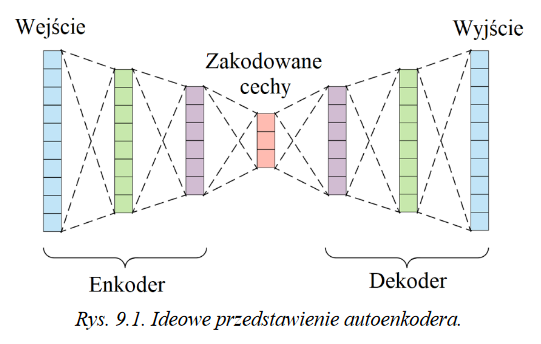

In [4]:
# loading the dataset
import numpy as np
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = np.expand_dims(X_train, axis=-1)
X_train_scaled = (X_train/255).copy()

In [6]:
# defining the autoencoder structure
from keras.layers import Conv2D, MaxPool2D,GlobalAveragePooling2D,Dense,Input, Reshape, UpSampling2D,BatchNormalization, GaussianNoise
from keras.models import Model
from keras.optimizers import Adam
act_func = 'selu'
aec_dim_num = 2
encoder_layers = [GaussianNoise(1),
                  BatchNormalization(),
                  Conv2D(32, (7,7),padding = 'same',activation=act_func),
                  MaxPool2D(2,2),
                  BatchNormalization(),
                  Conv2D(64, (5,5),padding = 'same',activation=act_func),
                  MaxPool2D(2,2),
                  BatchNormalization(),
                  Conv2D(128, (3,3),padding = 'same',activation=act_func),
                  GlobalAveragePooling2D(),
                  Dense(aec_dim_num, activation = 'tanh')]

decoder_layers = [Dense(128, activation = act_func),
                  BatchNormalization(),
                  Reshape((1,1,128)),
                  UpSampling2D((7,7)),
                  Conv2D(32, (3,3), padding = 'same',activation=act_func),
                  BatchNormalization(),
                  UpSampling2D((2,2)),
                  Conv2D(32, (5,5),padding = 'same',activation=act_func),
                  BatchNormalization(),
                  UpSampling2D((2,2)),
                  Conv2D(32, (7,7),padding = 'same',activation=act_func),
                  BatchNormalization(),
                  Conv2D(1, (3,3),padding = 'same',activation='sigmoid')]

lrng_rate = 0.0002
tensor = input_aec = input_encoder = Input(X_train.shape[1:])

for layer in encoder_layers:
  tensor = layer(tensor)
output_encoder = tensor
dec_tensor = input_decoder = Input(output_encoder.shape[1:])
for layer in decoder_layers:
  tensor = layer(tensor)
  dec_tensor = layer(dec_tensor)
output_aec = tensor
output_decoder = dec_tensor
autoencoder = Model(inputs = input_aec,outputs = output_aec)
encoder = Model(inputs = input_encoder,outputs = output_encoder)
decoder = Model(inputs = input_decoder,outputs = dec_tensor)
autoencoder.compile(optimizer=Adam(lrng_rate),loss='binary_crossentropy')
autoencoder.fit(x = X_train, y = X_train, epochs = 5, batch_size = 256) # epochs = 500

Epoch 1/5
235/235 [==============================] - 884s 4s/step - loss: -551.9709
Epoch 2/5
235/235 [==============================] - 886s 4s/step - loss: -1500.6967
Epoch 3/5
235/235 [==============================] - 865s 4s/step - loss: -2609.0491
Epoch 4/5
235/235 [==============================] - 872s 4s/step - loss: -3908.9248
Epoch 5/5
235/235 [==============================] - 873s 4s/step - loss: -5410.0195


186/186 [==============================] - 7s 36ms/step


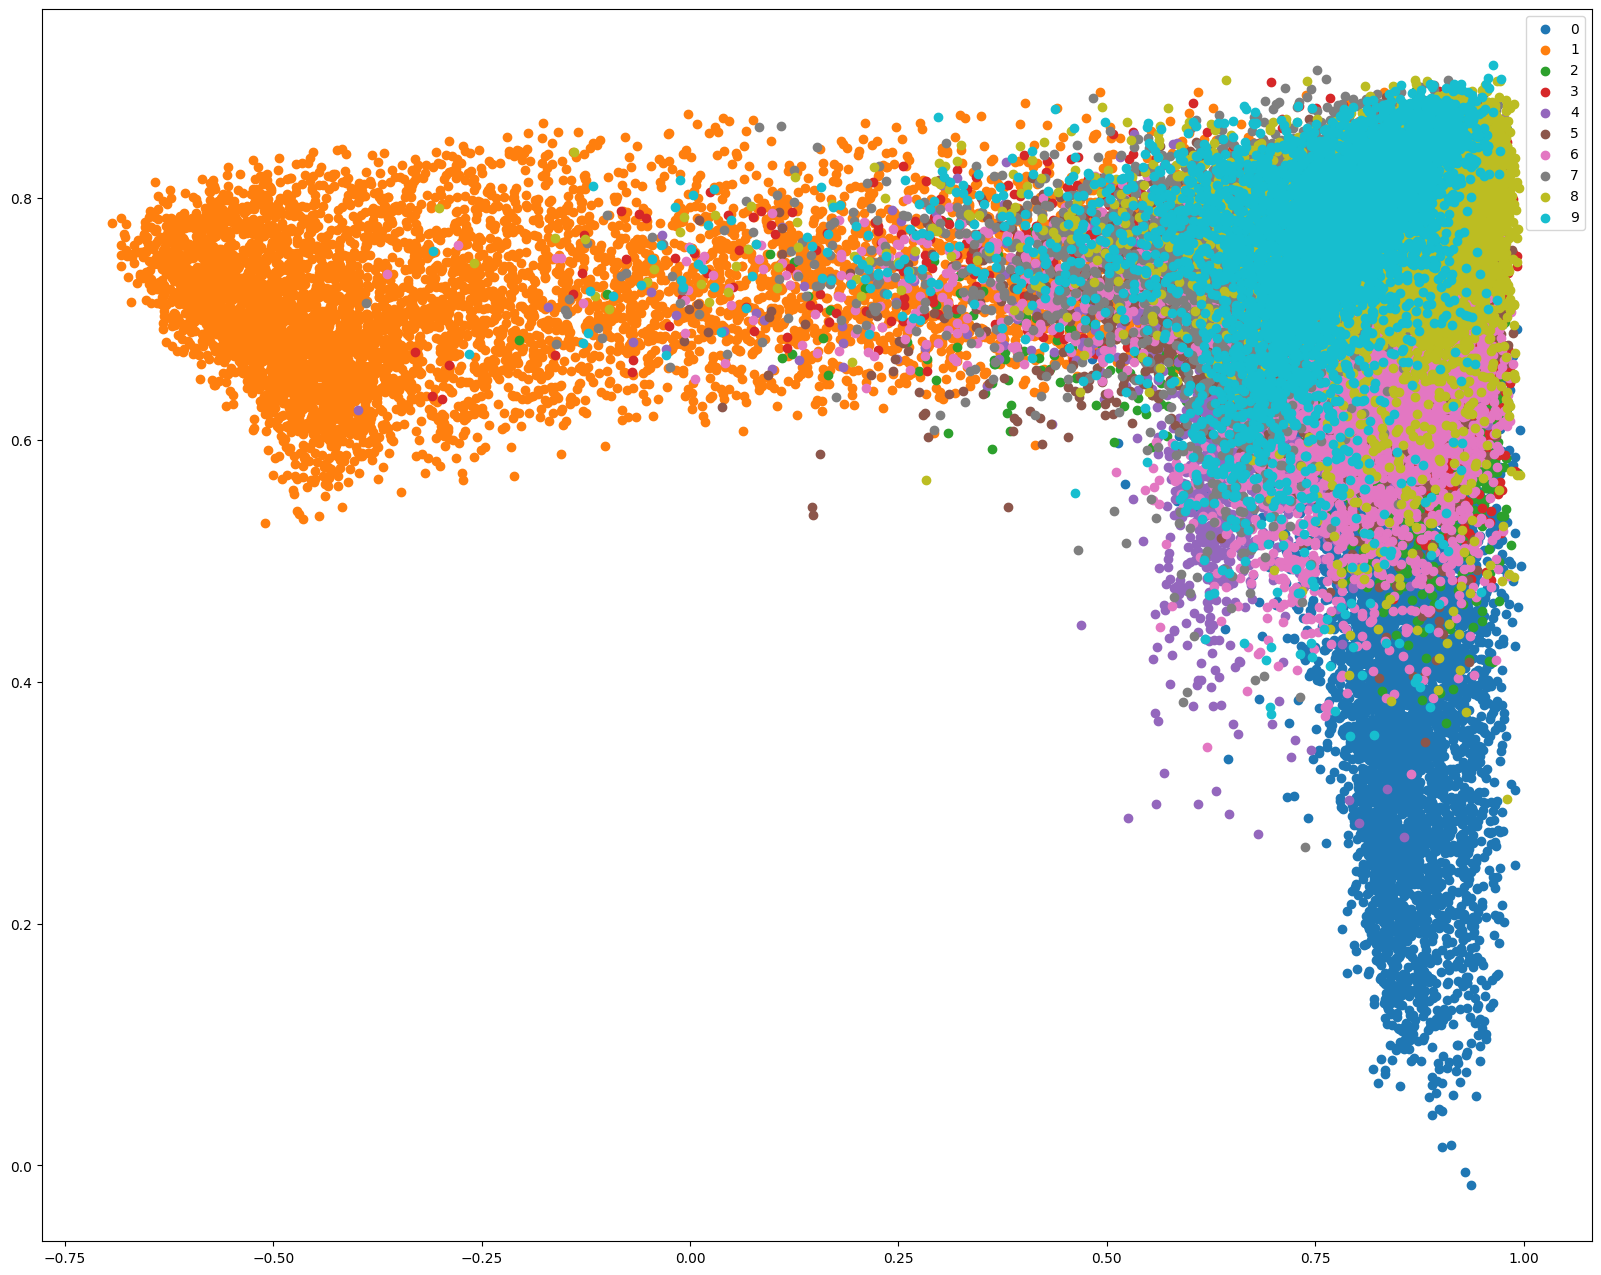

In [9]:
# representing learning data in the hiperparameters dimension
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize = (20,16))
for i in range(10):
  digits = y_train == i
  needed_imgs = X_train[digits,...]
  preds = encoder.predict(needed_imgs)
  ax.scatter(preds[:,0], preds[:,1])
ax.legend(list(range(10)))

1/1 [==============================] - 0s 26ms/step


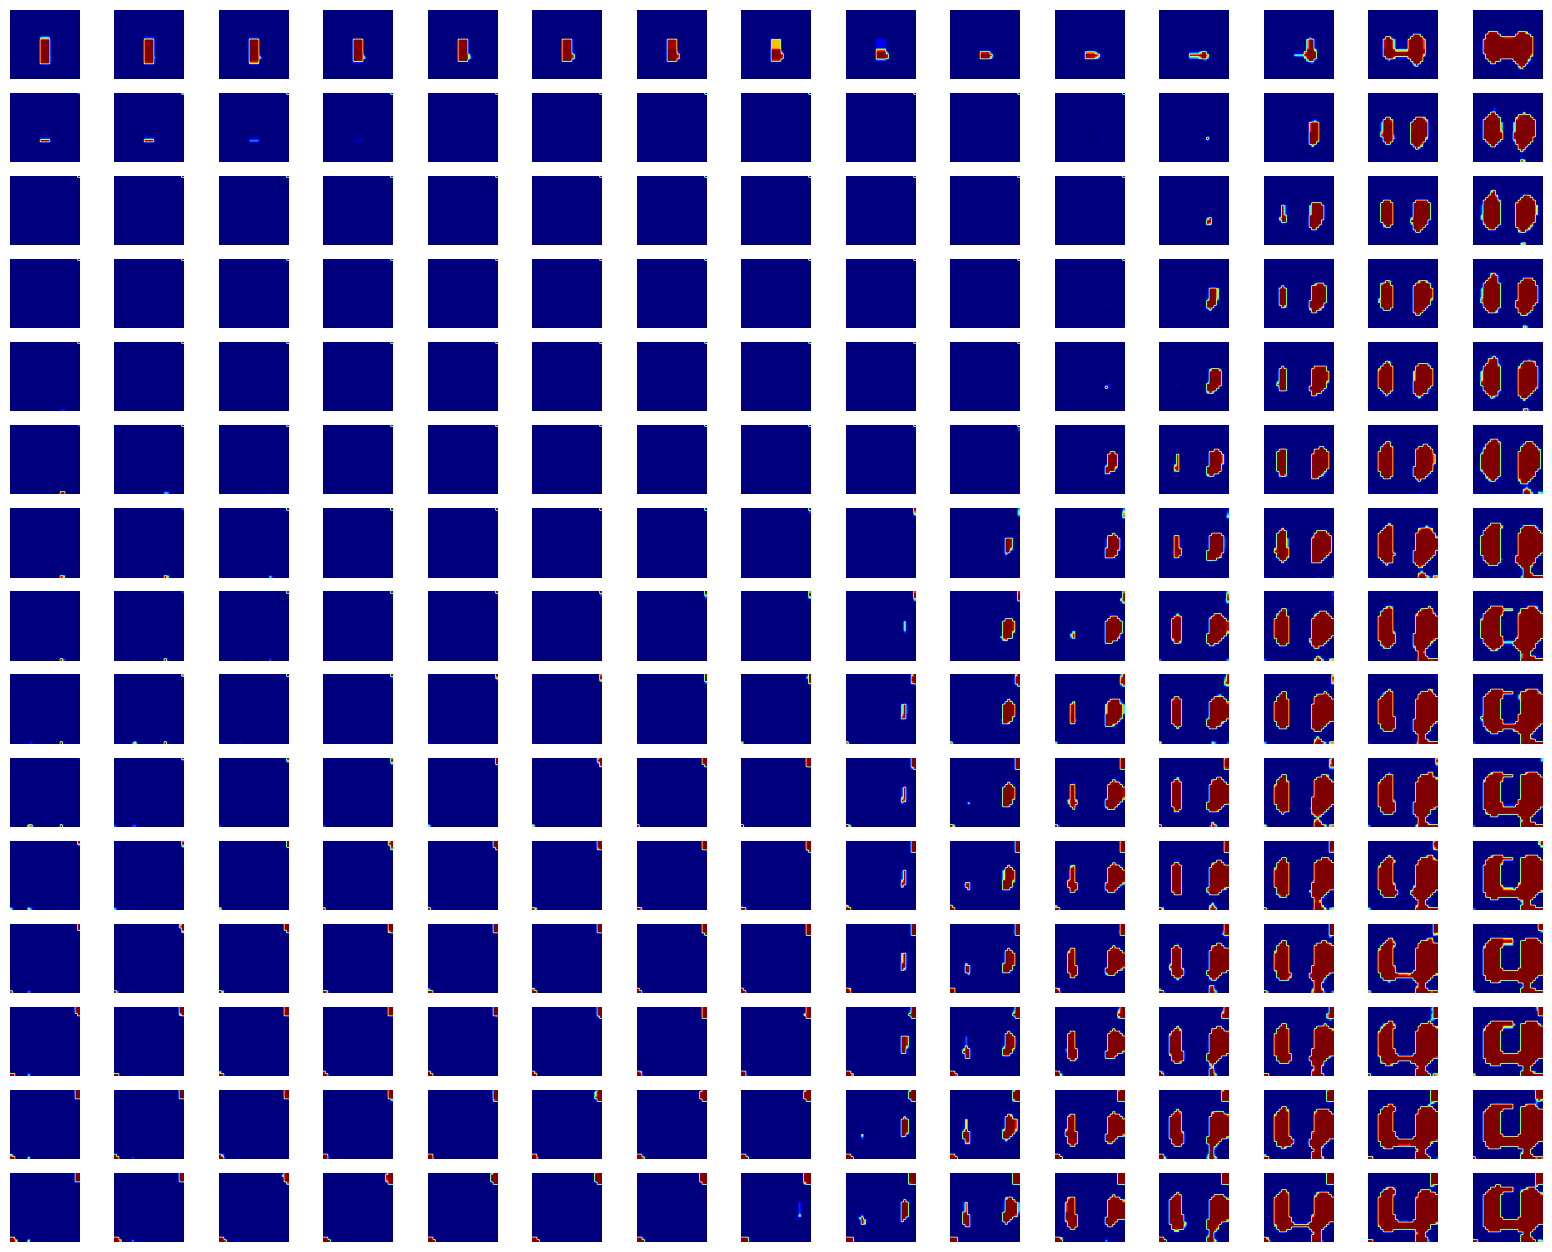

In [10]:
# generating the images based on the different hidden hiperparameters value
num = 15
limit = 0.6
step = limit*2/num
fig, ax = plt.subplots(num, num, figsize = (20,16))
X_vals = np.arange(-limit, limit, step)
Y_vals = np.arange(-limit, limit, step)
for i, x in enumerate(X_vals):
  for j, y in enumerate(Y_vals):
    test_in = np.array([[x,y]])
    output = decoder.predict(x=test_in)
    output = np.squeeze(output)
    ax[-j-1,i].imshow(output, cmap = 'jet')
    ax[-j-1,i].axis('off')

1/1 [==============================] - 1s 1s/step


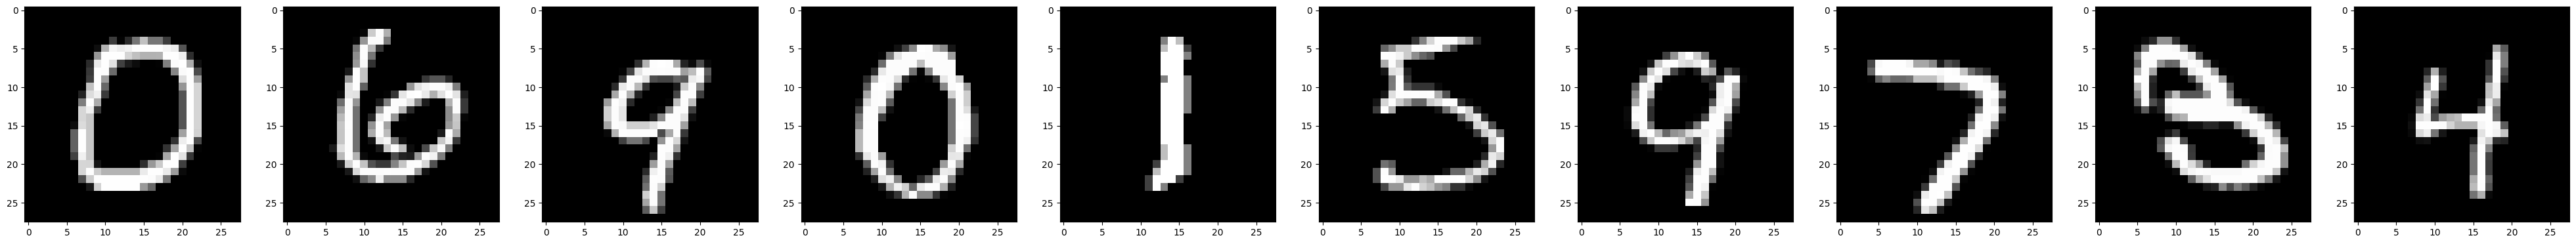

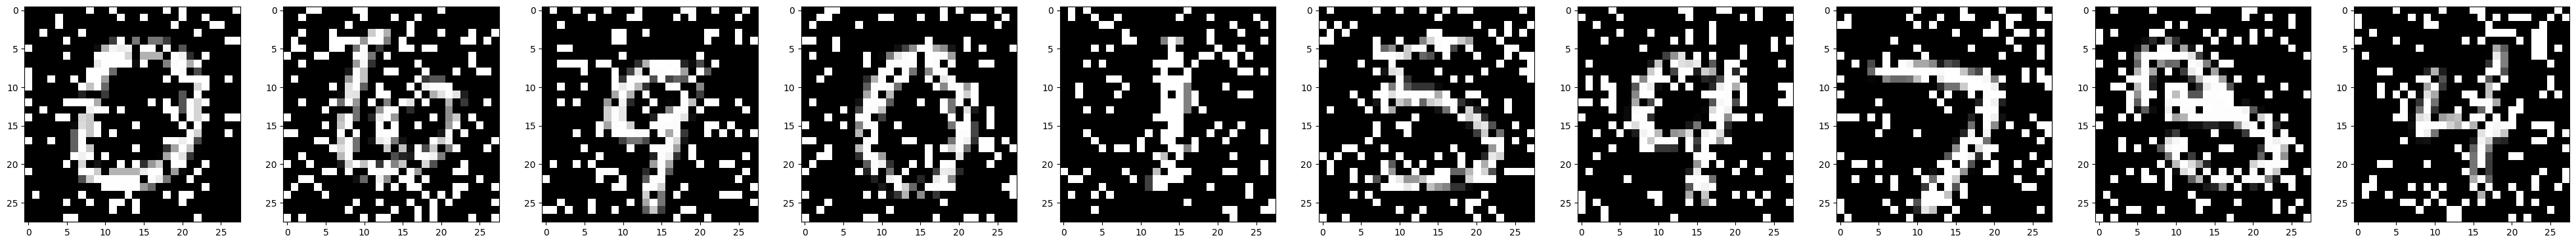

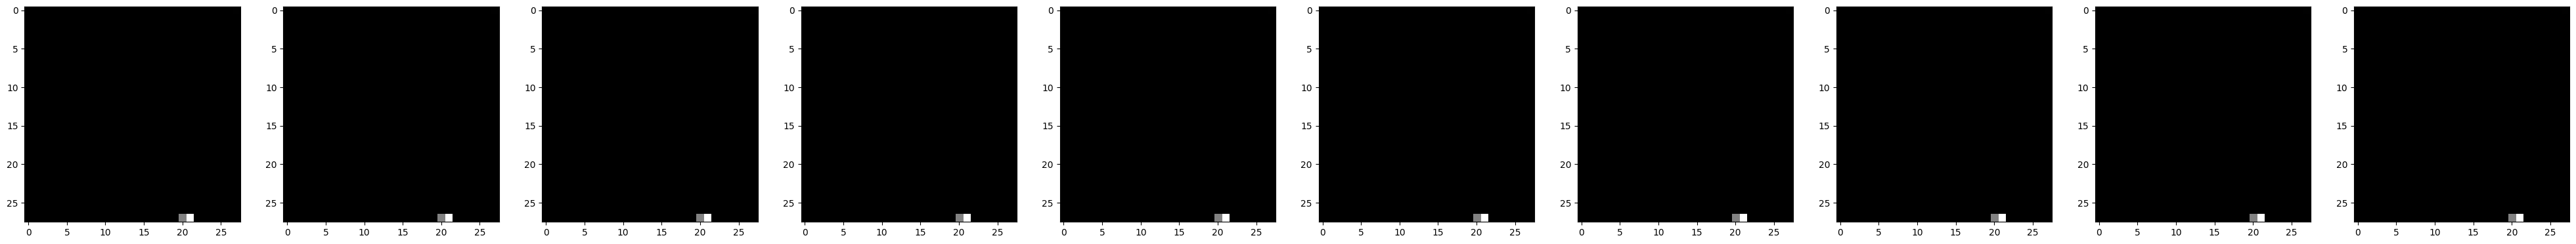

In [19]:
# Initialize noisy_test_photos
noisy_test_photos = X_test[10:20, ...].copy()

# generating noise images
test_photos = X_test[10:20,...].copy()
mask = np.random.randn(*test_photos.shape)
white = mask > 1
black = mask < -1
noisy_test_photos[white] = 255
noisy_test_photos[black] = 0
noisy_test_photos = noisy_test_photos.astype('float32') / 255  # Convert to float

# removing noise from images using autoencoder
def show_pictures(arrs):
  arr_cnt = arrs.shape[0]
  fig, axes = plt.subplots(1, arr_cnt, figsize=(5*arr_cnt, arr_cnt))
  for axis, pic in zip(axes, arrs):
    axis.imshow(pic.squeeze(), cmap = 'gray')
cleaned_images = autoencoder.predict(noisy_test_photos/255)*255
show_pictures(test_photos)
show_pictures(noisy_test_photos)
show_pictures(cleaned_images)